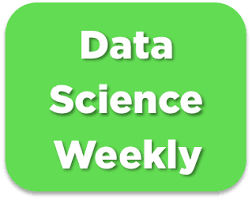

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import (
    BaggingClassifier,
    VotingClassifier
)
from xgboost import XGBClassifier

# import base estimators
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    classification_report,
    ConfusionMatrixDisplay,
    recall_score,
    RocCurveDisplay)

import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("datas/conversion_data_train_EDA.csv")

In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## Voting

In [4]:
target = "converted"

x = data.drop(target, axis = 1) 
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
numerical_columns = x_train.select_dtypes(include=["float", "int"]).columns
categorical_columns = x_train.select_dtypes(include="object").columns

display(x.head())
print("y :", y)
print("numerical_columns :", numerical_columns)
print("categorical_columns :", categorical_columns)

,country,age,new_user,source,total_pages_visited
0,China,22,1,Direct,2
1,UK,21,1,Ads,3
2,Germany,20,0,Seo,14
3,US,23,1,Seo,3
4,US,28,1,Direct,3


y : 0         0
1         0
2         1
3         0
4         0
         ..
283558    0
283559    0
283560    0
283561    0
283562    0
Name: converted, Length: 283563, dtype: int64
numerical_columns : Index(['age', 'new_user', 'total_pages_visited'], dtype='object')
categorical_columns : Index(['country', 'source'], dtype='object')


In [6]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ("encoder", OneHotEncoder(drop="first"))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_columns)
    ])

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

In [7]:
# Voting
from sklearn.utils.class_weight import compute_sample_weight

lr = LogisticRegression(class_weight={0: 1, 1: 2})
params = {"C": [0.1, 0.3, 0.5, 1]}
grid_search_lr = GridSearchCV(estimator=lr, param_grid=params, scoring="recall")
grid_search_lr.fit(x_train, y_train)

model = BaggingClassifier(estimator=lr)
params = {"estimator__C": [0.01, 0.05, 0.1, 0.3, 0.5, 1]}
grid_search_bg = GridSearchCV(model, param_grid=params, cv=3, scoring="recall") 
grid_search_bg.fit(x_train, y_train)


xgboost = XGBClassifier()
params = {
    "max_depth": [10, 15],
    "min_child_weight": [1, 5, 10],
    "n_estimators": [200]
}
grid_search_xg = GridSearchCV(xgboost, param_grid=params, cv=3, scoring="recall")
sample_weights = compute_sample_weight(class_weight={0: 1, 1: 2}, y=y_train)
grid_search_xg.fit(x_train, y_train, sample_weight=sample_weights)

# Voting
voting = VotingClassifier(
    estimators=[("logistic", grid_search_lr), ("bagging", grid_search_bg), ("xg", grid_search_xg)],
    voting="soft",
)
voting.fit(x_train, y_train)

print("Accuracy on training set : ", voting.score(x_train, y_train))
print("Accuracy on test set : ", voting.score(x_test, y_test))

Accuracy on training set :  0.9861229887590919
Accuracy on test set :  0.985858621480084


In [8]:
y_train_pred = voting.predict(x_train)
y_test_pred = voting.predict(x_test)

In [9]:
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

f1-score on training set :  0.7767375886524823
f1-score on test set :  0.7722884724588303

recall_score on training set :  0.7462523848460071
recall_score on test set :  0.7411444141689373


In [10]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    219512
           1       0.81      0.75      0.78      7338

    accuracy                           0.99    226850
   macro avg       0.90      0.87      0.88    226850
weighted avg       0.99      0.99      0.99    226850



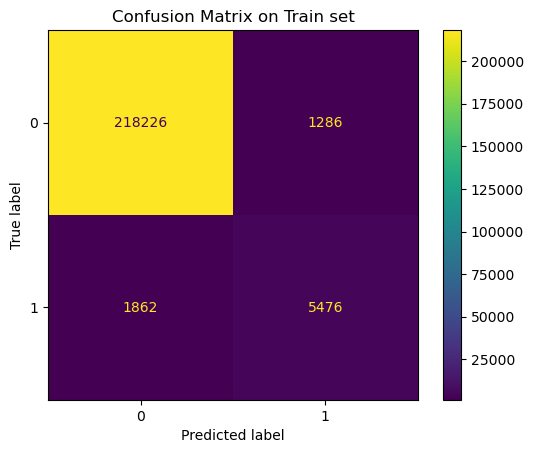

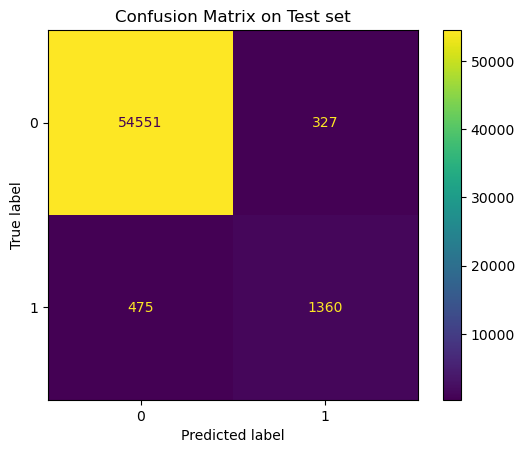

In [11]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    voting, x_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    voting, x_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

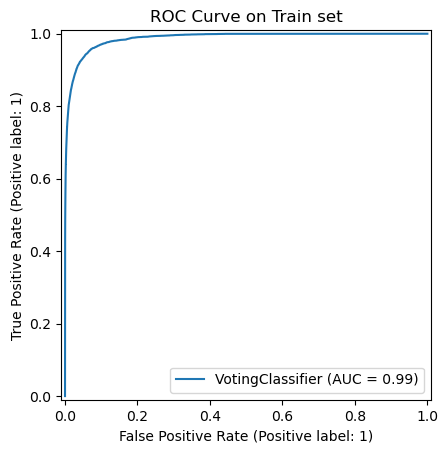

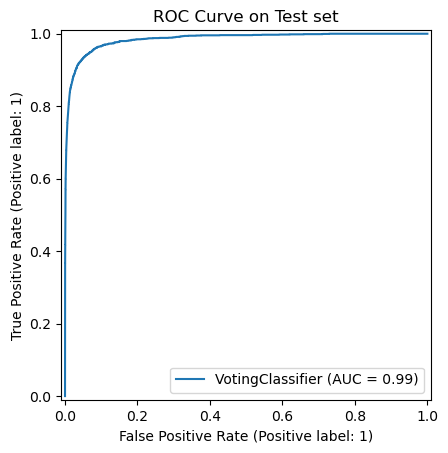

In [12]:
# Visualize ROC curves
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    voting, x_train, y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    voting, x_test, y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

----

## make predictions on X_without_labels

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv("datas/conversion_data_test_EDA.csv")

x_without_labels = data_without_labels

x_without_labels = preprocessor.transform(x_without_labels)
y_pred_without_label = voting.predict(x_without_labels)

# Read target without labels
y_without_labels = pd.read_csv("datas/conversion_data_test_labels_EDA.csv")

print("f1-score on set without labels : ", f1_score(y_without_labels, y_pred_without_label))
print()
print("recall_score on set without labels : ", recall_score(y_without_labels, y_pred_without_label))

f1-score on set without labels :  0.760635571501794

recall_score on set without labels :  0.7295968534906588


Sauvegarde de tous les résultats dans un dataframe

In [ ]:
scores_df = pd.DataFrame(columns = ["model", "f1", "recall"])

new_rows = [
    {"model": "voting", "f1": f1_score(y_without_labels, y_pred_without_label), "recall": recall_score(y_without_labels, y_pred_without_label)}
]

scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
scores_df.to_csv("datas/scores.csv", mode="a", header=False, index=False)

C:\Users\janda\AppData\Local\Temp\ipykernel_16840\1736323711.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
